In [26]:
!wandb login e778aaa40276b2e30de9a99724aeabc57cb5b67e

wandb: Appending key for api.wandb.ai to your netrc file: /home/intern/.netrc


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim import Adam
from utils.visualisation import showInRow
from data_loaders import get_data_loader
import pytorch_lightning as pl

import numpy as np

In [173]:
import wandb
wandb.init(project="ssl_rotation")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Accuracy,0.875
Loss,0.71213
_step,615
_runtime,259
_timestamp,1604608141


Accuracy,▁▂▂▂▃▃▃▄▅▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███████████████
Loss,█▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Load VGG

In [3]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=False)

Using cache found in /home/intern/.cache/torch/hub/pytorch_vision_v0.6.0


# Load Training dataset

In [4]:
class RotationWrapper(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        sample = self.base_dataset[idx]
        
        # Randomly rotate image 
        image = sample["image"]
        angle = np.random.randint(4)
        image = image.rotate(90*angle)
        
        # Create rotation label
        one_hot_label = np.zeros(4)
        one_hot_label[angle] = 1
        
        if self.transform:
            image = self.transform(image)
            
        
        sample["image"] = image
        sample["one_hot_label"] = torch.tensor(one_hot_label).float()
        sample["label"] = torch.tensor(angle)
        
        return sample

In [16]:
transform=transforms.Compose([#transforms.Grayscale(),
                              transforms.Resize((128,128)),
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5,), (0.5,))
                             ])

# Train model with rotations

In [164]:
class VGG_Rotation(pl.LightningModule):
    def __init__(self, model, num_classes, dataset, transform, mode="pretrain"):
        super().__init__()
        self.mode_outputs = {
            "train":num_classes,
            "pretrain":4
        }
        self.model = model
        self.num_classes = num_classes
        self.mode = mode
        self.switch_mode(mode)
        self.dataset = dataset
        self.transform = transform
        self.train_acc= pl.metrics.Accuracy()
        self.pretraining_loss_func = nn.CrossEntropyLoss()
        self.training_loss_func = torch.nn.MultiLabelSoftMarginLoss() # nn.BCEWithLogitsLoss()
        self.scheduler = None
        self.counter = torch.Tensor(0)
        
        
    def switch_mode(self, mode="pretrain"):
        if mode not in self.mode_outputs:
            print("Undefined mode", mode,", next available:", list(self.mode_outputs.keys()))
            print("Setting model for training instead.")
            mode = "train"
        self.mode = mode
        self.model.classifier[6] = nn.Linear(in_features=4096, 
                                             out_features=self.mode_outputs[self.mode], 
                                             bias=True)
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def multilabel_accuracy(self, logits, labels):
        N, C = logits.shape
        y_pred = torch.sigmoid(logits)
        y_pred = (y_pred > 0.5).float()
        accuracy = (label == y_pred).float().sum() / (N * C)
        return accuracy
    
    
    def training_step(self, batch, batch_idx):
        if self.mode == "pretrain":
            images, labels = \
                batch['image'], batch['label']
            images = images.cuda()
            labels = labels.cuda()
            logits = self(images)
            loss = self.pretraining_loss_func(logits, labels)
            wandb.log({"Accuracy": self.train_acc(torch.softmax(logits, 1, torch.float32), labels),
                       "Loss": loss})
        else:
            images, labels = \
                batch['image'], batch['one_hot_label']
            images = images.cuda()
            labels = labels.cuda()
            logits = self(images)
            y_pred = torch.sigmoid(logits)
            loss = self.training_loss_func(y_pred, labels)
            wandb.log({"Accuracy": self.multilabel_accuracy(logits, labels),
                       "Loss": loss})
        return loss
    
    def validation_step(self, batch, batch_idx):
        if self.mode == "pretrain":
            images, labels = \
                batch['image'], batch['label']
            images = images.cuda()
            labels = labels.cuda()
            logits = self(images)
            loss = self.pretraining_loss_func(logits, labels)
            wandb.log({"Accuracy": self.train_acc(torch.softmax(logits, 1, torch.float32), labels),
                       "Loss": loss})
        else:
            images, labels = \
                batch['image'], batch['one_hot_label']
            images = images.cuda()
            labels = labels.cuda()
            logits = self(images)
            loss = self.training_loss_func(logits, labels)
            wandb.log({"Accuracy": self.multilabel_accuracy(logits, labels),
                       "Loss": loss})
        
    
    def test_step(self, batch, batch_idx):
        if self.mode == "pretrain":
            images, labels = \
                batch['image'], batch['label']
            images = images.cuda()
            labels = labels.cuda()
            logits = self(images)
            _,y_pred = torch.max(logits, dim=1)
            self.counter += torch.sum(y_pred == labels) 
                
        
    def configure_optimizers(self):
        if self.mode == "pretrain":
            self.opt = Adam(self.parameters(), lr=1e-5)
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.opt, factor=0.1)
        else:
            self.opt = Adam(self.parameters(), lr=1e-7)
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.opt, factor=0.1)
        return [self.opt], [self.scheduler]
          
        
    def train_dataloader(self):
        if self.mode == "pretrain":
            train_raw = get_data_loader(self.dataset, part="train")
            train = RotationWrapper(train_raw, transform=self.transform)
        else:
            train = get_data_loader(self.dataset, part="train", transform=self.transform)    
        return DataLoader(train, batch_size=64, shuffle=True, num_workers=2)
    
    
    def val_dataloader(self):
        if self.mode == "pretrain":
            train_raw = get_data_loader(self.dataset, part="val")
            train = RotationWrapper(train_raw, transform=self.transform)
        else:
            train = get_data_loader(self.dataset, part="val", transform=self.transform)    
        return DataLoader(train, batch_size=64, shuffle=False, num_workers=2)

    
    def test_dataloader(self):
        if self.mode == "pretrain":
            test_raw = get_data_loader(self.dataset, part="test")
            test = RotationWrapper(test_raw, transform=self.transform)
        else:
            test = get_data_loader(self.dataset, part="test", transform=self.transform)    
        return DataLoader(test, batch_size=64, shuffle=False, num_workers=2)

In [174]:
vgg = VGG_Rotation(model, num_classes=15, dataset="Chest14", transform=transform)

In [166]:
vgg.switch_mode("pretrain")

In [167]:
if torch.cuda.is_available():
    vgg = vgg.cuda()

In [168]:
trainer = pl.Trainer(gpus=1, max_steps=50)
trainer.fit(vgg)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | model                 | VGG                      | 134 M 
1 | train_acc             | Accuracy                 | 0     
2 | pretraining_loss_func | CrossEntropyLoss         | 0     
3 | training_loss_func    | MultiLabelSoftMarginLoss | 0     


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8789d165f0>
Traceback (most recent call last):
  File "/home/intern/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/home/intern/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 927, in wait
    return ready
  File "/opt/conda/lib/python3.7/selectors.py", line 203, in __exit__
    self.close()
  File "/opt/conda/lib/python3.7/selectors.py", line 270, in close
    self._map = None
  File "/home/intern/.local/lib/python3.7/site

1

In [14]:
trainer.test(vgg)

/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------



1

In [15]:
vgg.counter

tensor([], device='cuda:0')

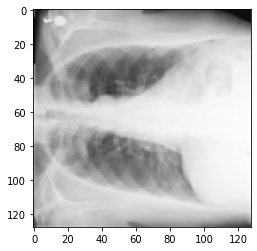

tensor([[1.0234e-04, 9.9990e-01, 7.7188e-07, 4.9919e-07]],
       grad_fn=<SoftmaxBackward>)

In [18]:
s = rotation_train[3]
showInRow([s["image"]], tensor=True)
inputs = s["image"].unsqueeze(0)
torch.softmax(vgg(inputs), 1, torch.float32)

In [19]:
vgg.train_acc(torch.softmax(vgg(inputs), 1, torch.float32), s["label"].unsqueeze(0))

tensor(1.)

In [175]:
vgg.switch_mode("train")

In [176]:
if torch.cuda.is_available():
    vgg = vgg.cuda()

In [177]:
trainer = pl.Trainer(gpus=1)
trainer.fit(vgg)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | model                 | VGG                      | 134 M 
1 | train_acc             | Accuracy                 | 0     
2 | pretraining_loss_func | CrossEntropyLoss         | 0     
3 | training_loss_func    | MultiLabelSoftMarginLoss | 0     


RuntimeError: DataLoader worker (pid(s) 17228) exited unexpectedly

In [19]:
train_loader = get_data_loader(vgg.dataset, part="train", transform=vgg.transform)  

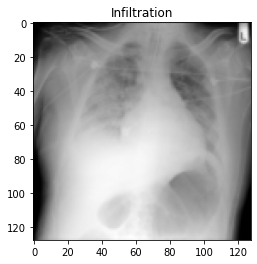

tensor([[0.7642, 0.2124, 0.0138, 0.0905, 0.0439, 0.2458, 0.0110, 0.0450, 0.1220,
         0.0609, 0.0129, 0.0322, 0.0095, 0.0221, 0.0049]], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [47]:
s = train_loader[41]
showInRow([s["image"]], [s["label"]],tensor=True)
inputs = s["image"].unsqueeze(0).cuda()
torch.sigmoid(vgg(inputs))

In [48]:
vgg.training_loss_func(vgg(inputs), s["one_hot_label"].unsqueeze(0).cuda())

tensor(0.2150, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [49]:
vgg.multilabel_accuracy(vgg(inputs), s["one_hot_label"].unsqueeze(0).cuda())

tensor(0., device='cuda:0')

In [50]:
s["one_hot_label"]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [56]:
a = torch.sigmoid(vgg(inputs))
print(a)
a > 0.5

tensor([[0.4409, 0.0592, 0.0984, 0.1206, 0.1161, 0.0192, 0.0321, 0.0316, 0.0143,
         0.0208, 0.0761, 0.0151, 0.0133, 0.0479, 0.0247]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False]], device='cuda:0')

In [52]:
vgg(inputs).shape

torch.Size([1, 15])

In [53]:
((a > 0.5) == s["one_hot_label"].unsqueeze(0).cuda()).sum()

tensor(13, device='cuda:0')

In [54]:
s["one_hot_label"].unsqueeze(0).sum(axis=1)

tensor([1.])

In [62]:
((a > 0.5)[s["one_hot_label"].unsqueeze(0).cuda() == 1] == s["one_hot_label"].unsqueeze(0).cuda()[s["one_hot_label"].unsqueeze(0).cuda() == 1]).sum(axis=0)

tensor(0, device='cuda:0')

In [64]:
(a > 0.5)[s["one_hot_label"].unsqueeze(0).cuda() == 1] 

tensor([False], device='cuda:0')

In [68]:
s["one_hot_label"].unsqueeze(0).cuda()[s["one_hot_label"].unsqueeze(0).cuda() == 0] = 2
s

{'image': tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.4157, 0.1804, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.4745, 0.2118, 0.0118],
          [0.0118, 0.0118, 0.0196,  ..., 0.5294, 0.2471, 0.0196],
          ...,
          [0.0157, 0.0863, 0.1765,  ..., 0.0039, 0.0039, 0.0039],
          [0.0275, 0.0902, 0.1765,  ..., 0.0039, 0.0078, 0.0039],
          [0.0353, 0.1020, 0.1882,  ..., 0.0039, 0.0078, 0.0039]],
 
         [[0.0078, 0.0078, 0.0078,  ..., 0.4157, 0.1804, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.4745, 0.2118, 0.0118],
          [0.0118, 0.0118, 0.0196,  ..., 0.5294, 0.2471, 0.0196],
          ...,
          [0.0157, 0.0863, 0.1765,  ..., 0.0039, 0.0039, 0.0039],
          [0.0275, 0.0902, 0.1765,  ..., 0.0039, 0.0078, 0.0039],
          [0.0353, 0.1020, 0.1882,  ..., 0.0039, 0.0078, 0.0039]],
 
         [[0.0078, 0.0078, 0.0078,  ..., 0.4157, 0.1804, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.4745, 0.2118, 0.0118],
          [0.0118, 0.0118, 0.01

In [149]:
label = s["one_hot_label"].unsqueeze(0).cuda()
label[0][0] =1.0
label

tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')

In [144]:
torch.sigmoid(vgg(inputs))

tensor([[0.9064, 0.0189, 0.0283, 0.0710, 0.0526, 0.0812, 0.0335, 0.3117, 0.0654,
         0.1733, 0.0621, 0.0620, 0.0079, 0.0746, 0.0077]], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [150]:
l(torch.sigmoid(vgg(inputs)), label)

tensor(0.6908, device='cuda:0', grad_fn=<MeanBackward0>)

In [141]:
vgg.training_loss_func(vgg(inputs), s["one_hot_label"].unsqueeze(0).cuda())

tensor(0.3692, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [152]:
y_pred = torch.sigmoid(vgg(inputs))
print(y_pred)
y_pred[y_pred >=0.5] = 1.0
y_pred[y_pred <0.5] = 0.0
label == y_pred

tensor([[0.6960, 0.1724, 0.3414, 0.2073, 0.1222, 0.0247, 0.0107, 0.0167, 0.1100,
         0.0033, 0.0878, 0.0209, 0.0305, 0.0274, 0.0256]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


tensor([[ True,  True,  True,  True, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True]], device='cuda:0')